# What is tweezepy?

A single-molecule pulling instrument, such as a magnetic tweezer (MT), optical trap (OT), and atomic force microscope (AFM), precisely and accurately manipulates molecules by tethering them to a probe. An essential part of these experiments is calibrating the applied force on the probe. 

Typically, calibrating the applied force is accomplished by comparing the probe trajectory to an analytical model derived from the Langevin equation. 
\begin{equation}
\kappa x + \alpha \dot{x} = F_L
\end{equation}
However, these comparisons are fraught with potential problems, including: 
1. The instrument response. 
2. Finite sampling distortions. 
3. Biased fitting. 

While there are established methods to handle or side-step each of these problems, they take substantial time and effort for researchers to learn and implement. This creates a substantial barrier to performing rigorous single-molecule pulling experiments.

To help overcome this barrier, we have made a freely available and open-source tool, [tweezepy](https://github.com/ianlmorgan/tweezepy), for calibrating single-molecule pulling experiments. The tool implements two widely used approaches, the power spectral density (PSD) and allan variance (AV), for low-error, bias-free methods of calibrating force. The tool is simple and straight-forward to use; basic usage only requires knowledge of the probe trajectory and sampling frequency. With this information, it calculates the applied force and associated uncertainty (a piece of information that is often overlooked).

In addition to its simplicity, tweezepy can also be used as a learning tool to highlight the different challenges in analyzing probe trajectories. It contains some common example data, analytical models, and analysis methods to demonstrate how an improper analysis can lead to misleading results.

In [21]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from tweezepy.smmcalibration import PSD,AV
from tweezepy.simulations import simulate_trace,downsampled_trace

# Example data

To test out tweezepy, we need example data. The easiest way to get example data is to simulate a probe trajectory with known $\alpha$ and $\kappa$. There are a couple strategies to do this, but the easiest method is to recast the Langevin equation as an equation of probability flux (a Smoluchowski equation), then apply an iterative scheme to generate successive discrete time points of the probe trajectory.
\begin{equation}
dx = \frac{dt}{\alpha}\left(\sqrt{\frac{2\alpha k_BT}{dt}} F_L-\kappa x_{i-1}\right) \\
x_i = x_{i-1}+dx
\end{equation}

The discrete time points from the above simulation represents a situation in which the probe motion is exactly as fast as the instrument measurement time, $\tau_s = 1/f_s$. In video-tracking experiments, e.g. magnetic and some optical tweezers, motion of the probe can occur on timescales faster than the measurement time - i.e. video tracking introduces a low-pass filter. To capture this low-pass filtering effect, we can simulate the probe position faster than the measurement time, then average groups of points together.

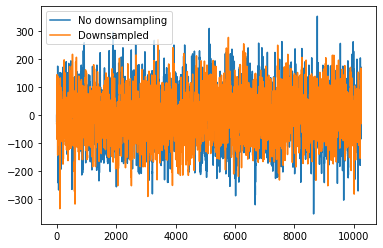

In [29]:
# Tada
fc = 10 # critical frequency
alpha = 1e-5 # dissipation due to viscous drag, in pN s/nm
             # 1e-5 is a typical value for an MT experiment
kappa = alpha*2*np.pi*fc # kappas in pN/nm
fsample = 400 # sampling frequency in Hz
N  = 10240 # number of points in trace
# No downsampling
xtrace = simulate_trace(alpha,kappa,fsample,N)
plt.plot(xtrace,label = 'No downsampling')
# With downsampling
xtrace = downsampled_trace(alpha,kappa,fsample,N)
plt.plot(xtrace,label = 'Downsampled')
plt.legend()
plt.show()

It's difficult to see any difference in the probe trajectory, however, the effect becomes much more pronounced at higher frequencies in the PSD.

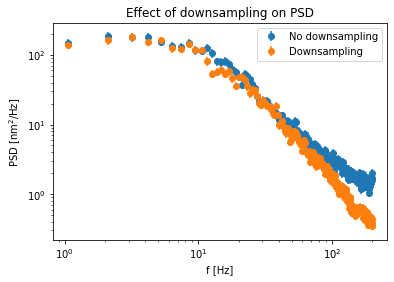

In [28]:
fig,ax = plt.subplots()
xtrace = simulate_trace(alpha,kappa,fsample,N)
psd = PSD(xtrace,fsample)
psd.plot(ax=ax,label = 'No downsampling')
xtrace = downsampled_trace(alpha,kappa,fsample,N)
psd = PSD(xtrace,fsample)
psd.plot(ax=ax,label = 'Downsampling')
ax.legend()
plt.title('Effect of downsampling on PSD')
plt.show()

Similarly, the downsampling effect is visible at smaller timescales $\tau$.

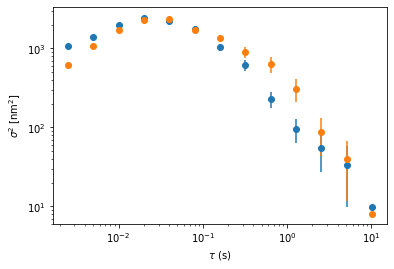

In [30]:
fig,ax = plt.subplots()
xtrace = simulate_trace(alpha,kappa,fsample,N)
av = AV(xtrace,fsample)
av.plot(ax=ax,label = 'No downsampling')
xtrace = downsampled_trace(alpha,kappa,fsample,N)
av = AV(xtrace,fsample)
av.plot(ax=ax,label = 'Downsampling')
plt.show()

We will use downsampled simulated trajectories from here on out, because it is closer to a real experiment.

# Basic tweezepy usage

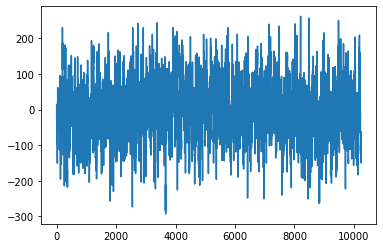

In [12]:
# Simlate the probe trajectory
fc = 10 # critical frequency
alpha = 1e-5 # dissipation due to viscous drag, in pN s/nm
             # 1e-5 is a typical value for an MT experiment
kappa = alpha*2*np.pi*fc # kappas in pN/nm
fsample = 400 # sampling frequency in Hz
N  = 10240 # number of points in trace
xtrace = downsampled_trace(alpha,kappa,fsample,N)
plt.plot(xtrace)

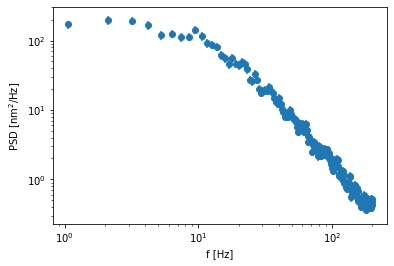

In [16]:
from tweezepy.smmcalibration import PSD,AV
# Calculating the power spectral density is as easy as:
psd = PSD(xtrace,fsample)
psd.plot()

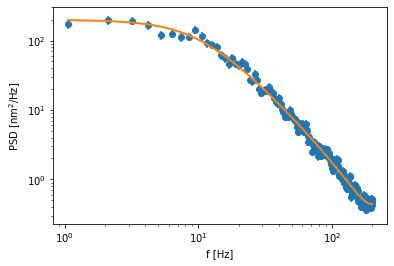

In [17]:
# Fitting to the power spectral density is as easy as:
pars,errs,covs = psd.mlefit()
psd.plot()

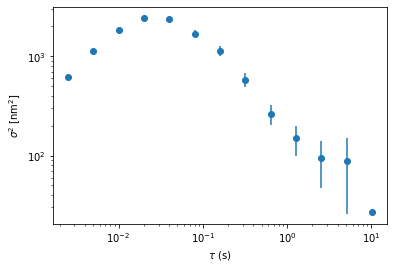

In [19]:
# Calculating the allan variance is as easy as:
av = AV(xtrace,fsample)
av.plot()

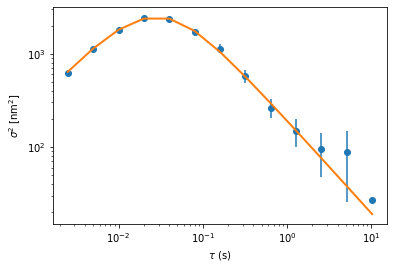

In [20]:
# Fitting the allan variance is as easy as:
av.mlefit(pedantic = False) # pedantic = False supresses annoying and unhelpful warnings from numpy
av.plot()

# The maximum likelihood method

The major advantage of the maximum likelihood fitting method is that it allows one to take into account the real noise distribution for each point in the PSD and AV. Instead of a normal distribution (implicitly assumed in nonlinear least squares fitting), the real noise distribution for each point is a Gamma distribution:
\begin{equation}
f(x;\eta,\theta) = x^{\eta-1}\frac{e^{-x/\theta}}{\theta^\eta\Gamma(\eta)}
\end{equation}
where $\Gamma(\eta)$ is the gamma function, $\eta$ is the shape parameter, and $\theta$ is the scale parameter. Explicitly using the Gamma distribution removes bias when fitting to the analytical functions. 

To fit an analytical function, we want to maximixe the likelihood function:
\begin{equation}
L = \prod_x f(x;\eta,\theta)
\end{equation}
However, a mathematically equivalent and practically easier method is minimizing the negative log-likelihood:
\begin{equation}
\log(L) = \sum_x \log(f(x;\eta,\theta))
\end{equation}
A minimum requires that the function be locally concave. Conviently for us, the gamma distribution is logarithmically concave. 

Luckily, to use tweezepy, you don't have to know any of this: it does it all for you "under the hood." 

Unfortunately, maximum likelihood fitting is not magic and has limitations. While maximum likelihood has the lowest asymptotic mean squared error compared to other fitting methods, if your data do not contain critical features, then you will have large parameter errors. 

Let's take a look at this by simulating PSD data with different critical frequencies, $f_c = \frac{\kappa}{2\pi\alpha}$.

In [47]:
alpha = 1e-5 # dissipation due to viscous drag, in pN s/nm
             # 1e-5 is a typical value for an MT experiment
N  = 10240 # number of points in trajectory
fsample = 400. # sampling frequency in Hz

def simulate_and_fit(kappa,N,**kwargs):
    xtrace = downsampled_trace(alpha,kappa,fsample,N)
    psd = PSD(xtrace,fsample)
    pars,errs,_ = psd.mlefit()
    label = '%.1f'%(kappa/(2*np.pi*alpha))
    psd.plot(**kwargs)
    return pars,errs

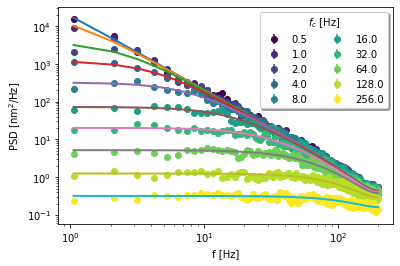

In [62]:

fcs = 2.**np.arange(-1,9)  # critical frequencies
colors = plt.cm.viridis(np.linspace(0,1,10))
fig,ax = plt.subplots()
for color,fc in zip(colors,fcs):
    kappa = alpha*2*np.pi*fc
    label = '%.1f'%fc
    trace = downsampled_trace(alpha,kappa,fsample,N)
    psd = PSD(trace,fsample)
    pars,errs,_ = psd.mlefit()
    psd.plot(ax=ax,label=label,color=color)
    fits.append([pars,errs])
plt.legend(title = '$f_c$ [Hz]',ncol=2,shadow = True)
plt.show()

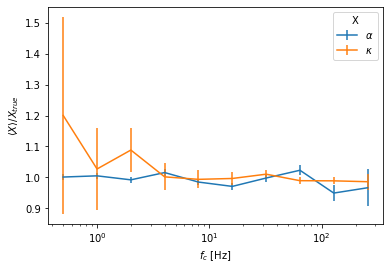

In [153]:
pars = np.array(fits[0]) # estimated parameters 
errs = np.array(fits[1])
plt.errorbar(fcs,pars.T[0]/alpha,yerr=errs.T[0]/alpha,label =r'$\alpha$')
plt.errorbar(fcs,pars.T[1]/kappas,yerr=errs.T[1]/kappas,label =r'$\kappa$')
plt.xscale('log')
plt.xlabel(r'$f_c$ [Hz]')
plt.ylabel(r'$\langle X\rangle/X_{true}$')
plt.legend(title = 'X')

When the critical frequency is poorly resolved, the fit to the PSD will perform worse (larger error). This is because noise reduction through blocking trades resolution on the frequency axis for resolution on the power axis. When the critical frequency is well-resolved by the data (points on either side of $f_c$), this trade off loses no information about the parameters. However, when there are so few points around the critical frequency, every point counts. 

To overcome this problem, the number of blocks in the PSD can be increased by changing the number of points per block. 

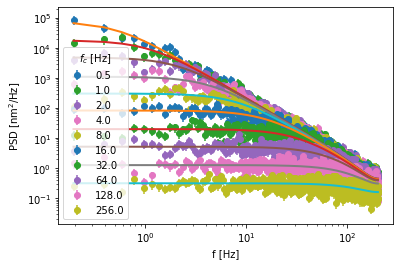

In [167]:
fig,ax = plt.subplots()
fits = []
for i,kappa in enumerate(kappas):
    xtrace = downsampled_trace(alpha,kappa,fsample,N)
    psd = PSD(xtrace,fsample,nperseg = N//5)
    pars,errors,covs = psd.mlefit()
    fits.append([pars,errors,covs])
    psd.plot(ax=ax,label = '%.1f'%(kappa/(2*np.pi*alpha)))
plt.legend(title = '$f_c$ [Hz]')
fits = list(zip(*fits))

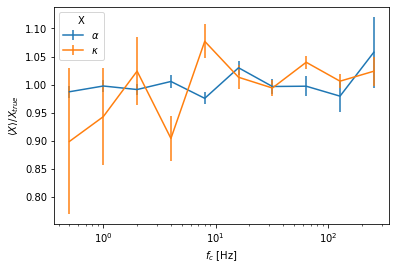

In [166]:
pars = np.array(fits[0]) # estimated parameters 
errs = np.array(fits[1])
plt.errorbar(fcs,pars.T[0]/alpha,yerr=errs.T[0]/alpha,label =r'$\alpha$')
plt.errorbar(fcs,pars.T[1]/kappas,yerr=errs.T[1]/kappas,label =r'$\kappa$')
plt.xscale('log')
plt.xlabel(r'$f_c$ [Hz]')
plt.ylabel(r'$\langle X\rangle/X_{true}$')
plt.legend(title = 'X')

The need to modify the number of blocks in such circumstances is one of the major downsides of using the PSD.

In contrast, the allan variance method has less ambiguity, i.e. there is no need to select the number of blocks. The default overlapping allan variance method most efficiently utilizes the data for all $f_c$. 

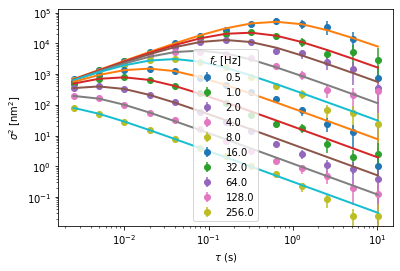

In [168]:
fig,ax = plt.subplots()
fits = []
for i,kappa in enumerate(kappas):
    xtrace = downsampled_trace(alpha,kappa,fsample,N)
    av = AV(xtrace,fsample)
    pars,errors,covs = av.mlefit(pedantic = False)
    fits.append([pars,errors,covs])
    av.plot(ax=ax,label = '%.1f'%(kappa/(2*np.pi*alpha)))
plt.legend(title = '$f_c$ [Hz]')
fits = list(zip(*fits))

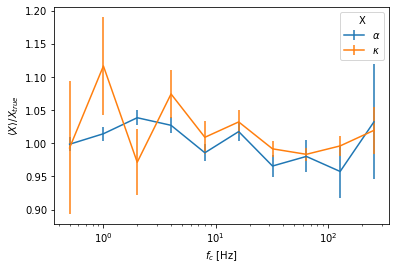

In [169]:
pars = np.array(fits[0]) # estimated parameters 
errs = np.array(fits[1])
plt.errorbar(fcs,pars.T[0]/alpha,yerr=errs.T[0]/alpha,label =r'$\alpha$')
plt.errorbar(fcs,pars.T[1]/kappas,yerr=errs.T[1]/kappas,label =r'$\kappa$')
plt.xscale('log')
plt.xlabel(r'$f_c$ [Hz]')
plt.ylabel(r'$\langle X\rangle/X_{true}$')
plt.legend(title = 'X')

TL;DR: While both methods work well, the allan variance tends to be simpler and more robust.

# Maximum likelihood parameter errors

An often overlooked part in calibrating the force in single-molecule pulling experiments is the uncertainty of the resulting force. The uncertainty, $\sigma(X)$, in the fit parameters scales with the amount of data, $N$, and the critical frequency, $f_c = \frac{\kappa}{2\pi\alpha}$: $\sigma(X)\propto \sqrt{\frac{f_c}{Nf_{sample}}}$. When there is a lot of data or the critical frequency is small compared to the sampling frequency, the parameter estimates are nearly exact. However, in some cases, such as at low forces in magnetic tweezer experiments, there may be an appreciable uncertainty in the applied force. 

## N-dependence

We expect the error on the fit parameters to scale with the number of points, $\sigma(X)\propto 1/\sqrt{N}$, where $X$ is either $\alpha$ or $\kappa$.

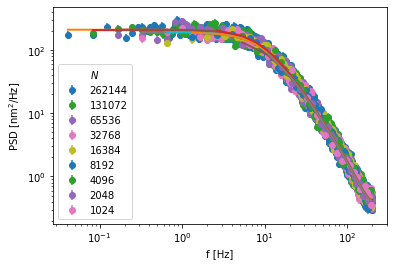

In [195]:
fc = 10 # in Hz
alpha = 1e-5 # dissipation due to viscous drag, in pN s/nm
             # 1e-5 is a typical value for an MT experiment
kappa = alpha*2*np.pi*fc # spring constant in pN/nm
lengths = 1024*2**np.arange(0,9)[::-1] # amount of data collected
fsample = 400. # sampling frequency for probe position
fig,ax = plt.subplots()
fits = []
for N in lengths:
    xtrace = downsampled_trace(alpha,kappa,fsample,N)
    psd = PSD(xtrace,fsample)
    pars,errors,covs = psd.mlefit(pedantic=False)
    fits.append([pars,errors,covs])
    psd.plot(ax=ax,label = N)
plt.legend(title = '$N$')
fits = list(zip(*fits))

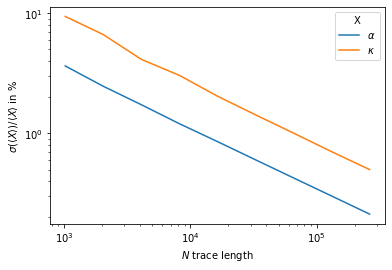

In [107]:
pars = np.array(fits[0])
errs = np.array(fits[1])
plt.loglog(lengths,100*errs.T[0]/pars.T[0],label =r'$\alpha$')
plt.loglog(lengths,100*errs.T[1]/pars.T[1],label =r'$\kappa$')
plt.xlabel(r'$N$ trace length')
plt.ylabel(r'$\sigma(\langle X\rangle)/\langle X\rangle$ in %')
plt.legend(title = 'X')

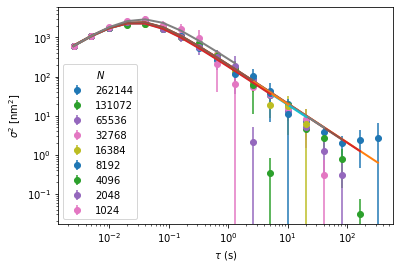

In [197]:
fig,ax = plt.subplots()
fits = []
for N in lengths:
    xtrace = downsampled_trace(alpha,kappa,fsample,N)
    av = AV(xtrace,fsample)
    pars,errors,covs = av.mlefit(pedantic = False)
    fits.append([pars,errors,covs])
    av.plot(ax=ax,label = N)
plt.legend(title = '$N$')
fits = list(zip(*fits))

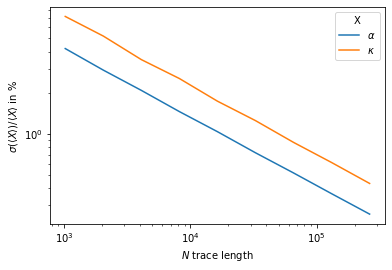

In [109]:
pars = np.array(fits[0])
errs = np.array(fits[1])
plt.loglog(lengths,100*errs.T[0]/pars.T[0],label =r'$\alpha$')
plt.loglog(lengths,100*errs.T[1]/pars.T[1],label =r'$\kappa$')
plt.xlabel(r'$N$ trace length')
plt.ylabel(r'$\sigma(\langle X\rangle)/\langle X\rangle$ in %')
plt.legend(title = 'X')

With both the PSD and AV, we see that errors scale as expected.

## $f_c$- dependence

As we saw in Section 4, we expect a larger error on the fit parameters, $\sigma(X)$, when the critical frequency, $f_c$, is poorly resolved in the data.

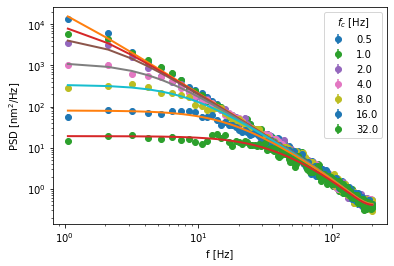

In [176]:
fcs = 2.**np.arange(-1,6) # critical frequencies
alpha = 1e-5 # dissipation due to viscous drag, in pN s/nm
             # 1e-5 is a typical value for an MT experiment
kappas = alpha*2*np.pi*fcs # kappas in pN/nm
fsample = 400. # sampling frequency in Hz
N  = 10240 # number of points in trace
fig,ax = plt.subplots()
fits = []
for kappa in kappas:
    xtrace = downsampled_trace(alpha,kappa,fsample,N)
    psd = PSD(xtrace,fsample)
    pars,errors,covs = psd.mlefit()
    fits.append([pars,errors,covs])
    psd.plot(ax=ax,label = '%.1f'%(kappa/(2*np.pi*alpha)))
ax.legend(title = '$f_c$ [Hz]')
fits = list(zip(*fits))

C:\Users\ianmo\Anaconda3\lib\site-packages\numpy\ma\core.py:6759: RuntimeWarning: underflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


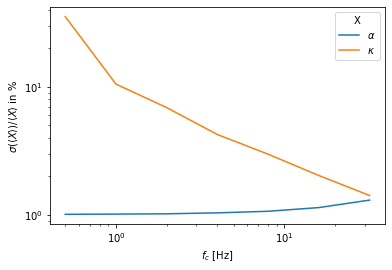

In [177]:
pars = np.array(fits[0]) # estimated parameters 
errs = np.array(fits[1]) # estimated errors
plt.loglog(fcs,100*errs.T[0]/pars.T[0],label =r'$\alpha$')
plt.loglog(fcs,100*errs.T[1]/pars.T[1],label =r'$\kappa$')
plt.xlabel(r'$f_c$ [Hz]')
plt.ylabel(r'$\sigma(\langle X\rangle)/\langle X\rangle$ in %')
plt.legend(title = 'X')

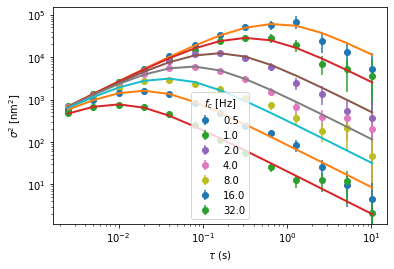

In [179]:
fig,ax = plt.subplots()
fits = []
for kappa in kappas:
    xtrace = downsampled_trace(alpha,kappa,fsample,N)
    av = AV(xtrace,fsample)
    pars,errors,covs = av.mlefit(pedantic = False)
    fits.append([pars,errors,covs])
    av.plot(ax=ax,label = '%.1f'%(kappa/(2*np.pi*alpha)))
ax.legend(title = '$f_c$ [Hz]')
fits = list(zip(*fits))

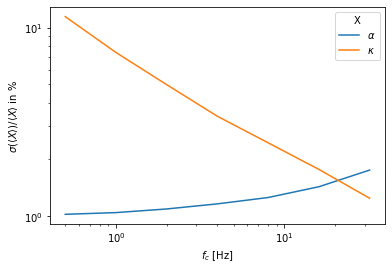

In [181]:
pars = np.array(fits[0]) # estimated parameters 
errs = np.array(fits[1]) # estimated errors
plt.loglog(fcs,100*errs.T[0]/pars.T[0],label =r'$\alpha$')
plt.loglog(fcs,100*errs.T[1]/pars.T[1],label =r'$\kappa$')
plt.xlabel(r'$f_c$ [Hz]')
plt.ylabel(r'$\sigma(\langle X\rangle)/\langle X\rangle$ in %')
plt.legend(title = 'X')

We see that $\kappa$ shows the expected trend but $\alpha$ does not. This is because information about the parameters is not only contained at the critical frequency. Information about $\kappa$ is also contained at smaller frequencies (PSD) and larger timescales (AV), while information about $\alpha$ is contained at larger frequencies (PSD) and smaller timescales (AV). Hence, when $f_c<<f_{sample}$, $\kappa$ will have larger error. Conversely, when $f_c\sim f_{sample}$, $\alpha$ will have larger error. 

To say it another way: Reducing error in $\kappa$ requires collecting data over a longer time. Reducing error in $\alpha$ requires collecting data faster.   

## n-dependence

As we alluded to in Section 4, when using the PSD to analyze probe trajectories, there are a few extra steps. 

To use the PSD, the probe trajectory needs to be windowed and blocked into $b$ blocks of length $m$. Blocking the data into half-overlapping bins, $b=2N/m - 1$, (Welch's method) most efficiently utilizes the data. The PSDs for each block are averaged together to give the averaged PSD, $P_b=\sum{P_m/b}$. The resulting PSD has several desirable qualities, such as less spectral leakage and stochastic noise, as well as a more normal noise distribution.

However, the downside to this method is that there is some ambiguity, *a priori*, in determining the correct number of blocks. As we have already seen, when $f_c$ is poorly resolved, the number of blocks can have an appreciable effect on the error on $\kappa$. Luckily, when $f_c$ is well-resolved, the number of blocks only has a small (<1%) effect on fitting error. This is because the maximum likelihood fit accounts for the real noise distribution and doesn not assume a normal noise distribution.

Ideally, in calculating the PSD, one would like to divide the trajectory into the minimum number of blocks that sufficiently reduces stochastic noise. There is a shallow minimum around b=27, hence, the default number of blocks in tweezepy is 27. This can modified easily by changing the parameter "nperseg", i.e. the number of points per block, $m$.

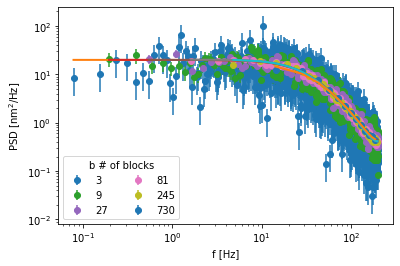

In [188]:
N = 10240
b = 3**np.arange(1,7) # of blocks
npersegs = (2*N)//(b+1) # of points per segment
fig,ax = plt.subplots()
fits = []
fc = 10
for m in npersegs:
    xtrace = downsampled_trace(alpha,kappa,fsample,N)
    psd = PSD(xtrace,fsample,nperseg = m)
    pars,errors,covs = psd.mlefit(pedantic = False)
    fits.append([pars,errors,covs])
    psd.plot(ax=ax,label = 2*N//m - 1)
plt.legend(ncol = 2,title = 'b # of blocks')
fits = list(zip(*fits))

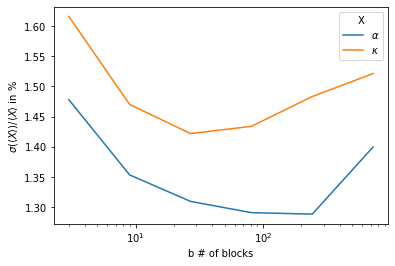

In [189]:
pars = np.array(fits[0])
errs = np.array(fits[1])
plt.semilogx(b,100*errs.T[0]/pars.T[0],label =r'$\alpha$')
plt.semilogx(b,100*errs.T[1]/pars.T[1],label =r'$\kappa$')
plt.xlabel(r'b # of blocks')
plt.ylabel(r'$\sigma(\langle X\rangle)/\langle X\rangle$ in %')
plt.legend(title = 'X')